In [1]:
!git clone https://github.com/marijal74/ml_pix2pix.git

Cloning into 'ml_pix2pix'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 168 (delta 94), reused 149 (delta 82), pack-reused 0
Receiving objects: 100% (168/168), 4.60 MiB | 19.71 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
!rm -r ml_pix2pix/

In [2]:
from ml_pix2pix.src.discriminator import Discriminator
from ml_pix2pix.src.generator import UNet
from ml_pix2pix.src import utils
from ml_pix2pix.src import losses
from ml_pix2pix.src.process_data import ImageDataset, Pix2PixDataset
from ml_pix2pix.src import process_data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import time
import multiprocessing

# Loading the Dataset

Using a custom class for loading a dataset using an enum.

In [3]:
pix2pix_dataset = Pix2PixDataset.FACADES
print("Which dataset:" + pix2pix_dataset.value)
print("Dataset url:" + pix2pix_dataset.get_url())
print("Batch size: {}, epochs: {}".format(pix2pix_dataset.batch_size(), pix2pix_dataset.num_epochs()))

Which dataset:facades
Dataset url:http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Pix2PixDataset.FACADES
Batch size: 1, epochs: 200


In [4]:
batch_size = pix2pix_dataset.batch_size()
epochs = pix2pix_dataset.num_epochs()

Pix2PixDataset.FACADES


Downloading the dataseet into `data` folder with `train`, `val` and `test` subfolders. All images are paired. `ImageDataset` class subclasses `pytorch.Dataset` class. When fetching a sample from a dataset, a sample is being preprocessed using transformations described in the original paper.

In [5]:
process_data.download_dataset(pix2pix_dataset)

Creating data folder


In [6]:
train_dataset = ImageDataset(pix2pix_dataset)
train_dataset.load_dataset()

In [7]:
print('Images in train dataset: {}'.format(train_dataset.__len__()))

Images in train dataset: 400


In [8]:
num_threads = multiprocessing.cpu_count()
print(f'Number of available threads:{num_threads}')

Number of available threads:2


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=num_threads)

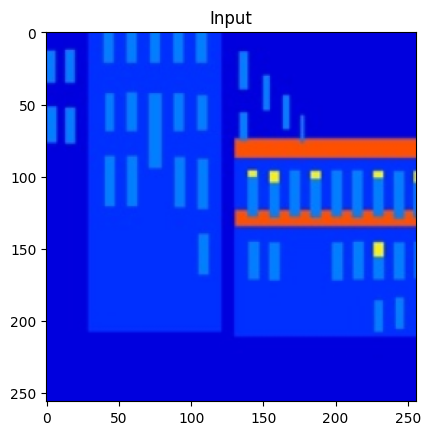

In [10]:
item = train_dataset.__getitem__(0)
plt.imshow(item[0].permute(1, 2, 0))
plt.title('Input')
plt.show()

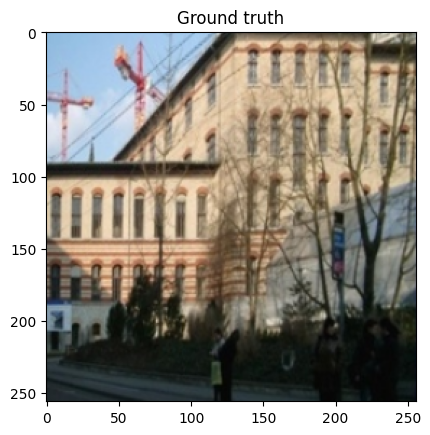

In [11]:
plt.imshow(item[1].permute(1, 2, 0))
plt.title('Ground truth')
plt.show()

# Creating the model

In [12]:
if (torch.cuda.is_available()):
  device = 'cuda'
  print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
  print(f"CUDA version: {torch.version.cuda}")

  # Storing ID of current CUDA device
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")

  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
else:
  device = 'cpu'
  print('No cuda available')



Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:Tesla T4


In [13]:
print(device)

cuda


In [14]:
generator = UNet()
generator.eval()

UNet(
  (input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [15]:
discriminator = Discriminator(num_channels = 3)
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [16]:
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

# Training

In [17]:
inputs, targets = next(iter(train_dataloader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [18]:
inputs.shape

torch.Size([1, 3, 256, 256])

In [19]:
disc_opt = losses.get_optimizer(discriminator.parameters())
gen_opt = losses.get_optimizer(generator.parameters())

In [20]:
disc_losses = []
gen_losses = []
num_of_steps = len(train_dataloader)

Epoch: 1


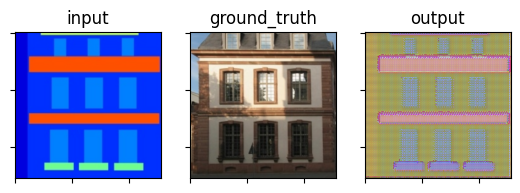

End of epoch 1 Time taken: 25.502739429473877
End of epoch 2 Time taken: 24.408053398132324
End of epoch 3 Time taken: 24.142863035202026
End of epoch 4 Time taken: 23.745707511901855
End of epoch 5 Time taken: 23.849318742752075
End of epoch 6 Time taken: 24.03107452392578
End of epoch 7 Time taken: 23.94498872756958
End of epoch 8 Time taken: 23.831951379776
End of epoch 9 Time taken: 23.81153106689453
End of epoch 10 Time taken: 23.861600637435913
Epoch: 11


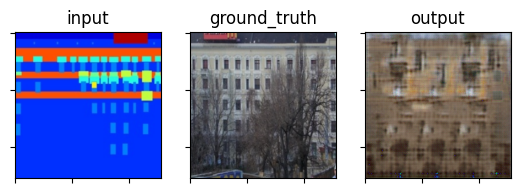

End of epoch 11 Time taken: 24.20859980583191
End of epoch 12 Time taken: 23.888832807540894
End of epoch 13 Time taken: 23.88711428642273
End of epoch 14 Time taken: 23.88709330558777
End of epoch 15 Time taken: 23.882649660110474
End of epoch 16 Time taken: 23.91576361656189
End of epoch 17 Time taken: 23.88377857208252
End of epoch 18 Time taken: 23.89011001586914
End of epoch 19 Time taken: 23.881869077682495
End of epoch 20 Time taken: 23.852586269378662
Epoch: 21


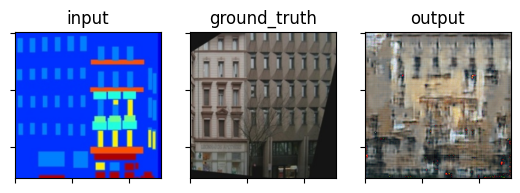

End of epoch 21 Time taken: 24.300338983535767
End of epoch 22 Time taken: 23.878387689590454
End of epoch 23 Time taken: 23.9113347530365
End of epoch 24 Time taken: 23.967153549194336
End of epoch 25 Time taken: 23.898767948150635
End of epoch 26 Time taken: 23.879882097244263
End of epoch 27 Time taken: 23.89583396911621
End of epoch 28 Time taken: 23.896658897399902
End of epoch 29 Time taken: 23.89021635055542
End of epoch 30 Time taken: 23.91392493247986
Epoch: 31


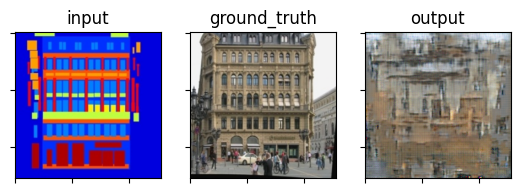

End of epoch 31 Time taken: 24.274815320968628
End of epoch 32 Time taken: 23.90463376045227
End of epoch 33 Time taken: 23.943974256515503
End of epoch 34 Time taken: 24.05043911933899
End of epoch 35 Time taken: 24.001171588897705
End of epoch 36 Time taken: 23.980759143829346
End of epoch 37 Time taken: 23.97550892829895
End of epoch 38 Time taken: 23.986894369125366
End of epoch 39 Time taken: 23.97554636001587
End of epoch 40 Time taken: 23.96045160293579
Epoch: 41


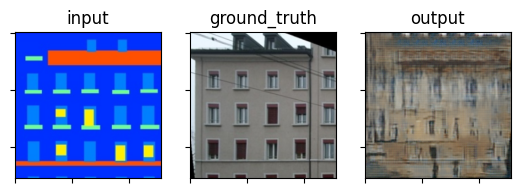

End of epoch 41 Time taken: 24.312820434570312
End of epoch 42 Time taken: 23.959176063537598
End of epoch 43 Time taken: 24.045044660568237
End of epoch 44 Time taken: 24.09968113899231
End of epoch 45 Time taken: 23.9832706451416
End of epoch 46 Time taken: 23.989362955093384
End of epoch 47 Time taken: 23.98242497444153
End of epoch 48 Time taken: 24.09423041343689
End of epoch 49 Time taken: 24.050466299057007
End of epoch 50 Time taken: 24.224320888519287
Epoch: 51


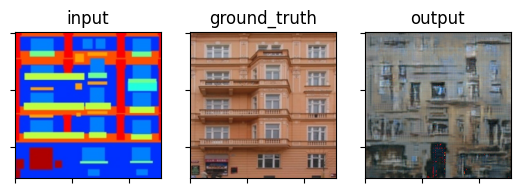

End of epoch 51 Time taken: 24.76719069480896
End of epoch 52 Time taken: 24.03181529045105
End of epoch 53 Time taken: 24.08196759223938
End of epoch 54 Time taken: 23.98920750617981
End of epoch 55 Time taken: 24.006985664367676
End of epoch 56 Time taken: 24.019631147384644
End of epoch 57 Time taken: 24.00949239730835
End of epoch 58 Time taken: 23.99939203262329
End of epoch 59 Time taken: 23.975183725357056
End of epoch 60 Time taken: 23.947486877441406
Epoch: 61


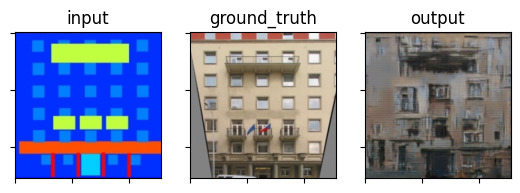

End of epoch 61 Time taken: 24.313895225524902
End of epoch 62 Time taken: 23.979055404663086
End of epoch 63 Time taken: 24.158169507980347
End of epoch 64 Time taken: 24.12970232963562
End of epoch 65 Time taken: 24.021990060806274
End of epoch 66 Time taken: 24.005297422409058
End of epoch 67 Time taken: 24.04776668548584
End of epoch 68 Time taken: 23.97844123840332
End of epoch 69 Time taken: 23.965134620666504
End of epoch 70 Time taken: 24.001768350601196
Epoch: 71


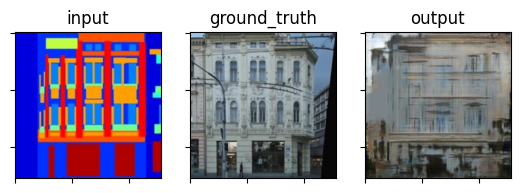

End of epoch 71 Time taken: 24.468313217163086
End of epoch 72 Time taken: 24.21222972869873
End of epoch 73 Time taken: 24.2218816280365
End of epoch 74 Time taken: 24.15426778793335
End of epoch 75 Time taken: 24.025851726531982
End of epoch 76 Time taken: 23.99900460243225
End of epoch 77 Time taken: 23.99518918991089
End of epoch 78 Time taken: 23.998945236206055
End of epoch 79 Time taken: 24.010290384292603
End of epoch 80 Time taken: 24.00286889076233
Epoch: 81


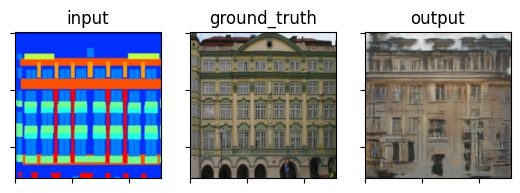

End of epoch 81 Time taken: 24.332035064697266
End of epoch 82 Time taken: 24.086238622665405
End of epoch 83 Time taken: 24.199955224990845
End of epoch 84 Time taken: 24.161519765853882
End of epoch 85 Time taken: 24.08716320991516
End of epoch 86 Time taken: 24.06480860710144
End of epoch 87 Time taken: 24.073838472366333
End of epoch 88 Time taken: 24.06377863883972
End of epoch 89 Time taken: 24.052985668182373
End of epoch 90 Time taken: 24.053775787353516
Epoch: 91


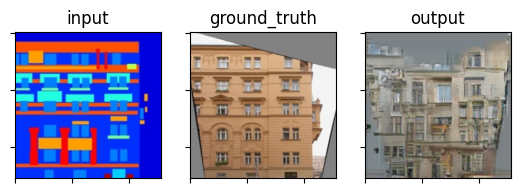

End of epoch 91 Time taken: 24.388827323913574
End of epoch 92 Time taken: 24.16200876235962
End of epoch 93 Time taken: 24.222002744674683
End of epoch 94 Time taken: 24.292637586593628
End of epoch 95 Time taken: 24.194096326828003
End of epoch 96 Time taken: 24.097549438476562
End of epoch 97 Time taken: 24.106528997421265
End of epoch 98 Time taken: 24.08687424659729
End of epoch 99 Time taken: 24.083757400512695
End of epoch 100 Time taken: 24.10375213623047
Epoch: 101


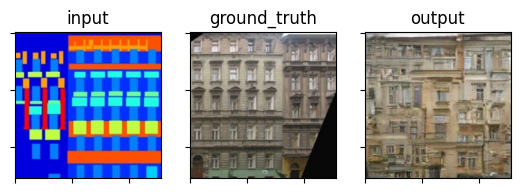

End of epoch 101 Time taken: 24.43248414993286
End of epoch 102 Time taken: 24.12602972984314
End of epoch 103 Time taken: 24.164795398712158
End of epoch 104 Time taken: 24.294192790985107
End of epoch 105 Time taken: 24.289419412612915
End of epoch 106 Time taken: 24.211137533187866
End of epoch 107 Time taken: 24.11063551902771
End of epoch 108 Time taken: 24.090675830841064
End of epoch 109 Time taken: 24.111546277999878
End of epoch 110 Time taken: 24.096253395080566
Epoch: 111


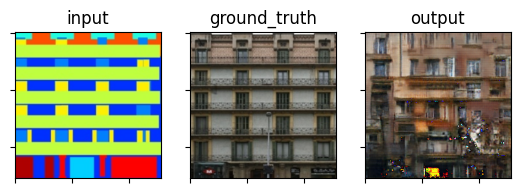

End of epoch 111 Time taken: 24.4673490524292
End of epoch 112 Time taken: 24.14713144302368
End of epoch 113 Time taken: 24.152711153030396
End of epoch 114 Time taken: 24.299283742904663
End of epoch 115 Time taken: 24.205995798110962
End of epoch 116 Time taken: 24.357467651367188
End of epoch 117 Time taken: 24.237702131271362
End of epoch 118 Time taken: 24.109111785888672
End of epoch 119 Time taken: 24.141493797302246
End of epoch 120 Time taken: 24.144091606140137
Epoch: 121


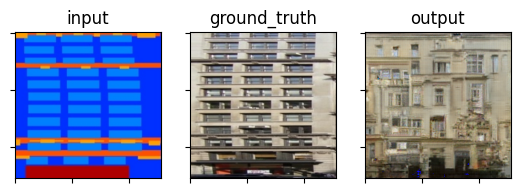

End of epoch 121 Time taken: 24.53080987930298
End of epoch 122 Time taken: 24.25910758972168
End of epoch 123 Time taken: 24.155721187591553
End of epoch 124 Time taken: 24.163591623306274
End of epoch 125 Time taken: 24.27630114555359
End of epoch 126 Time taken: 24.376498460769653
End of epoch 127 Time taken: 24.36638617515564
End of epoch 128 Time taken: 24.318711519241333
End of epoch 129 Time taken: 24.19708514213562
End of epoch 130 Time taken: 24.17891836166382
Epoch: 131


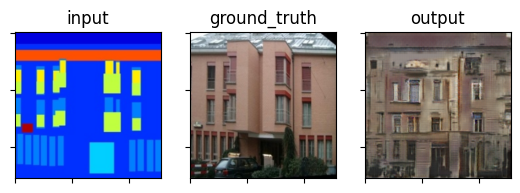

End of epoch 131 Time taken: 25.587427139282227
End of epoch 132 Time taken: 24.192293167114258
End of epoch 133 Time taken: 24.259928941726685
End of epoch 134 Time taken: 24.32731318473816
End of epoch 135 Time taken: 24.212454557418823
End of epoch 136 Time taken: 24.3468120098114
End of epoch 137 Time taken: 24.39821147918701
End of epoch 138 Time taken: 24.505886554718018
End of epoch 139 Time taken: 24.386282920837402
End of epoch 140 Time taken: 24.25942611694336
Epoch: 141


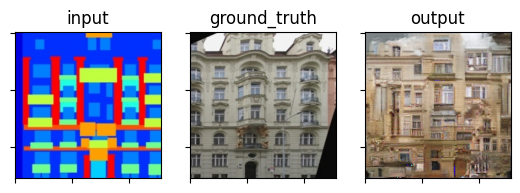

End of epoch 141 Time taken: 24.855079174041748
End of epoch 142 Time taken: 24.23153805732727
End of epoch 143 Time taken: 24.232201099395752
End of epoch 144 Time taken: 24.263194799423218
End of epoch 145 Time taken: 24.24935245513916
End of epoch 146 Time taken: 24.243957996368408
End of epoch 147 Time taken: 24.250226497650146
End of epoch 148 Time taken: 24.35036540031433
End of epoch 149 Time taken: 24.34402632713318
End of epoch 150 Time taken: 24.437767267227173
Epoch: 151


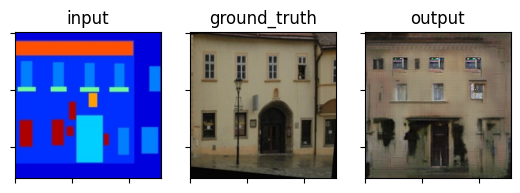

End of epoch 151 Time taken: 24.96932816505432
End of epoch 152 Time taken: 24.41422939300537
End of epoch 153 Time taken: 24.25345468521118
End of epoch 154 Time taken: 24.274722576141357
End of epoch 155 Time taken: 24.365365505218506
End of epoch 156 Time taken: 24.275612354278564
End of epoch 157 Time taken: 24.278493404388428
End of epoch 158 Time taken: 24.30641770362854
End of epoch 159 Time taken: 24.287516832351685
End of epoch 160 Time taken: 24.388697624206543
Epoch: 161


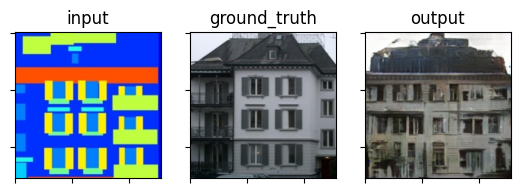

End of epoch 161 Time taken: 24.78103017807007
End of epoch 162 Time taken: 24.551851272583008
End of epoch 163 Time taken: 24.532086610794067
End of epoch 164 Time taken: 24.494373083114624
End of epoch 165 Time taken: 24.318638563156128
End of epoch 166 Time taken: 24.366220474243164
End of epoch 167 Time taken: 24.340245962142944
End of epoch 168 Time taken: 24.338073015213013
End of epoch 169 Time taken: 24.37771439552307
End of epoch 170 Time taken: 24.3678936958313
Epoch: 171


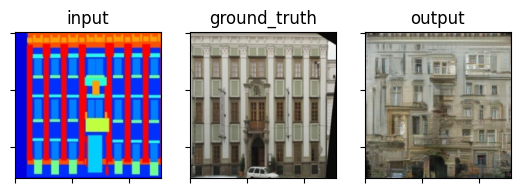

End of epoch 171 Time taken: 24.715322017669678
End of epoch 172 Time taken: 24.372870445251465
End of epoch 173 Time taken: 24.36397647857666
End of epoch 174 Time taken: 24.53204083442688
End of epoch 175 Time taken: 24.41131615638733
End of epoch 176 Time taken: 24.649338006973267
End of epoch 177 Time taken: 24.552571058273315
End of epoch 178 Time taken: 24.487236499786377
End of epoch 179 Time taken: 24.396161556243896
End of epoch 180 Time taken: 24.39495587348938
Epoch: 181


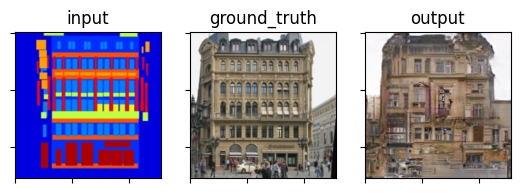

End of epoch 181 Time taken: 24.735015630722046
End of epoch 182 Time taken: 24.339232444763184
End of epoch 183 Time taken: 24.371501207351685
End of epoch 184 Time taken: 24.366328477859497
End of epoch 185 Time taken: 24.353673696517944
End of epoch 186 Time taken: 24.36517071723938
End of epoch 187 Time taken: 24.374763011932373
End of epoch 188 Time taken: 24.45160460472107
End of epoch 189 Time taken: 24.482852935791016
End of epoch 190 Time taken: 24.602673530578613
Epoch: 191


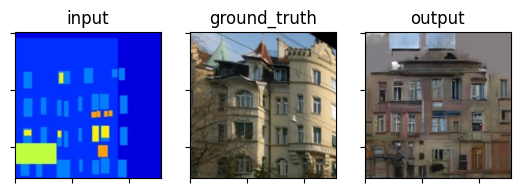

End of epoch 191 Time taken: 25.189157724380493
End of epoch 192 Time taken: 24.63232111930847
End of epoch 193 Time taken: 24.521775722503662
End of epoch 194 Time taken: 24.33995771408081
End of epoch 195 Time taken: 24.32356095314026
End of epoch 196 Time taken: 24.32687020301819
End of epoch 197 Time taken: 24.37554097175598
End of epoch 198 Time taken: 24.55333399772644
End of epoch 199 Time taken: 24.393016576766968
End of epoch 200 Time taken: 24.386484622955322


In [21]:
for epoch in range(epochs):
  start_time = time.time()
  epoch_gen_loss = 0.0
  epoch_disc_loss = 0.0
  for step, (inputs, targets) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    epoch_disc_loss += losses.train_discriminator_step(discriminator, generator, inputs, targets, disc_opt, device)
    gen_loss, generated_image = losses.generator_training_step(discriminator, generator, inputs, targets, gen_opt, device, L1_lambda = 75)
    epoch_gen_loss += gen_loss

    if(epoch % 10 == 0 and step == 0):
      print(f'Epoch: {epoch+1}')
      utils.print_sample(inputs[step], targets[step], generated_image)

  print(f'End of epoch {epoch+1} Time taken: {time.time() - start_time}')
  disc_losses.append(epoch_disc_loss / num_of_steps)
  gen_losses.append(epoch_gen_loss / num_of_steps)


In [22]:
!mkdir saved_models

In [23]:
torch.save(generator.state_dict(), 'saved_models/facades_generator_dict_75.pth')
torch.save(generator, 'saved_models/facades_generator_75.pth')
torch.save(discriminator.state_dict(), 'saved_models/facades_discriminator_dict_75.pth')
torch.save(discriminator, 'saved_models/facades_discriminator_75.pth')

In [24]:
discriminator_losses = list(map(lambda el: el.item(), disc_losses))
generator_losses = list(map(lambda el: el.item(), gen_losses))

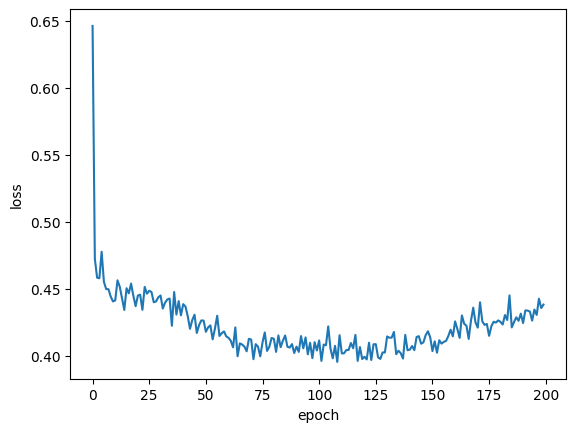

In [25]:
utils.plot_loss(discriminator_losses)

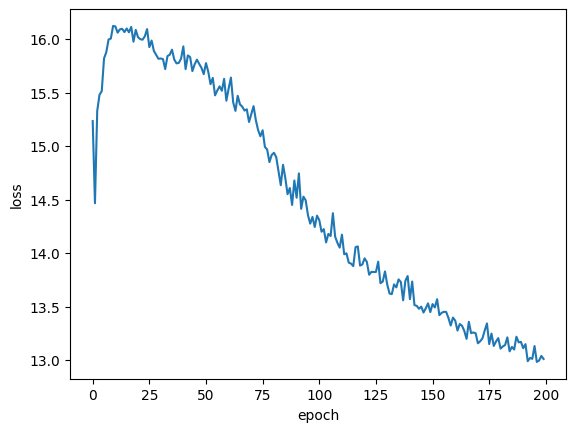

In [26]:
utils.plot_loss(generator_losses)

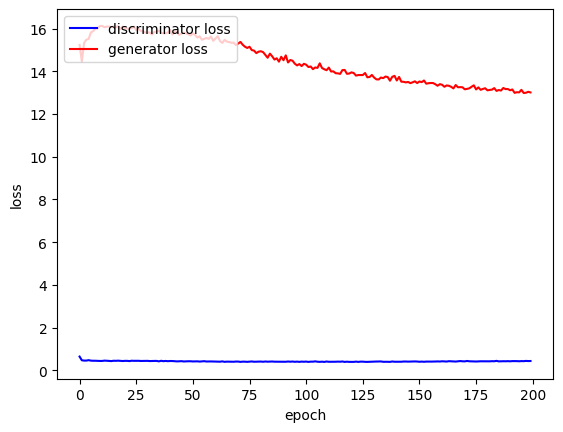

In [27]:
utils.plot_losses(discriminator_losses, generator_losses)

#Testing

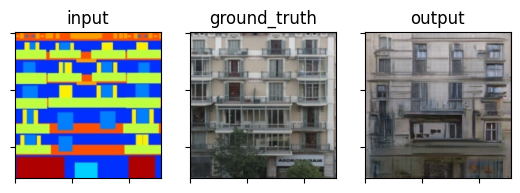

In [33]:
test_dataset = ImageDataset(pix2pix_dataset)
test_dataset.load_dataset()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True, num_workers=num_threads)

inputs, targets = next(iter(test_dataloader))
gen = generator(inputs.to(device))

utils.print_sample(inputs[0], targets[0], gen)